In [1]:
import requests
from IPython.core.display import HTML
# HTML(f"""
# <style>
# @import "https://cdn.jsdelivr.net/npm/bulma@0.9.4/css/bulma.min.css";
# </style>
# """)

# Assignment introduction

**Overview**
This is the first mandatory assignment in which you will implement an affine regression model to estimate where a person is looking (this is known as _gaze_) from images of eyes.
Carefully read through the entire assignment to get an overview of the problem and the tasks before solving the assignment.
Refer to the bottom of the page for **submission details**.
**Note:** **Important!** Complete all tasks marked with **high (red)** priority before attempting to solve the others, as they are optional. Optional tasks and further analysis can help improve results, but feel free to explore methods and data as you choose.


The assignment builds on the Data preprocessing
 exercise. It uses the data in the `sessions`
 folder both `test_subject_0`
, `test_subject_1`
 as well as your own collected data.
The assignment has multiple steps:
1. Train gaze estimation models using data from `test_subject_0`
 training set.    - Test the models using `test_subject_0`
 test set.
    - Test the models using `test_subject_1`
.


2. Train gaze estimation models using data from `test_subject_1`
, `grid`
.    - Test the models using `test_subject_1`
. 


3. Train gaze estimtion models using your own data set. 


**Note**
The steps contains repeated elements, but duplicate code to keep results in each cell asociated to each step. This makes it easier to review during the exam.
Most visualization and data processing code is located in `iml_util.py`
, but you're not expected to explain it. Focus on the code provided in the assignment.

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

**Note:** The location of the _fovea_ on the retina varies between people ($\pm$ 5 degrees). Consequently, a gaze model has to be trained (calibrated) for a specific person to be accurate. This difference is shown in [Figure 1](#kappa).

## Gaze Estimation introduction
Gaze estimation is performed by capturing images of a user's eye as shown in [Figure 2](#model) and mapping them to screen positions using a function $f_\mathbf{w}(x, y)$. Humans look at things by orienting their eyes so that the light from the point of focus hits the _Fovea_ (a point on the retina). The Fovea is not directly aligned with the center of the pupil, but at a person-specific angle, as shown in [Figure 1](#kappa). The pupil position can be used to infer gaze, but to obtain accurate gaze estimates requires training data (called calibration).


</div>

<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">



</div>


<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: left; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="kappa">

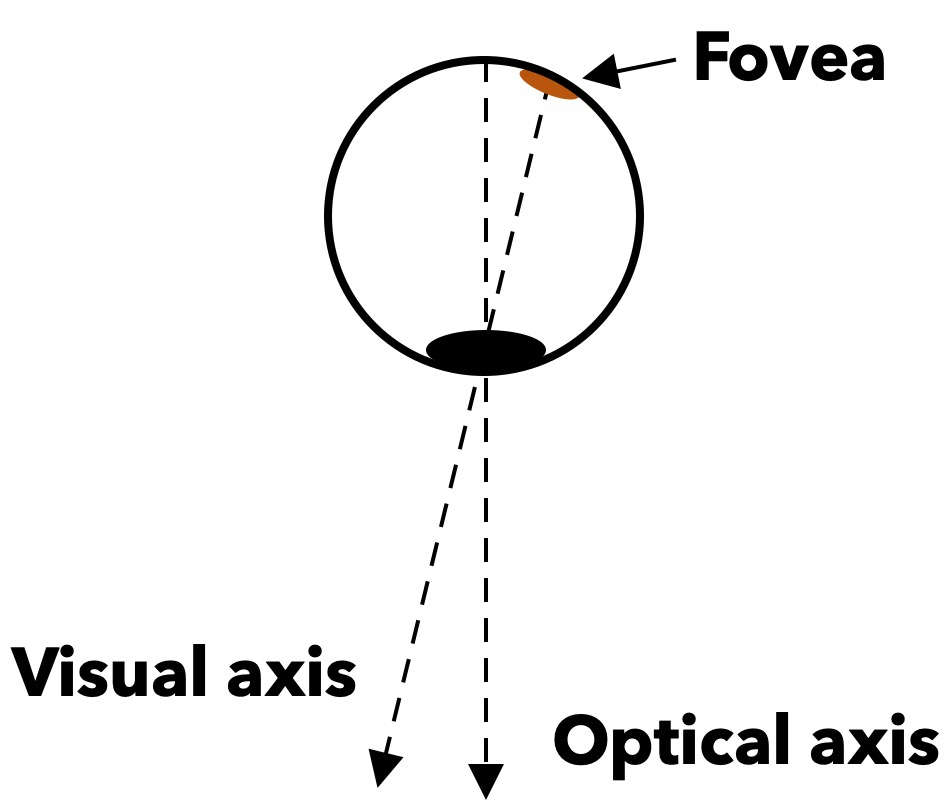

<figcaption class="figure-caption has-text-left">Figure 1: The distinction between the visual and optical axes. The optical axis is defined as an axis perpendicular to the lens behind the pupil. The visual axis depends on the placement of the _fovea_.
</figcaption>
</figure>
</div>


</div>

<div style="float: right; width: 50%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="model">

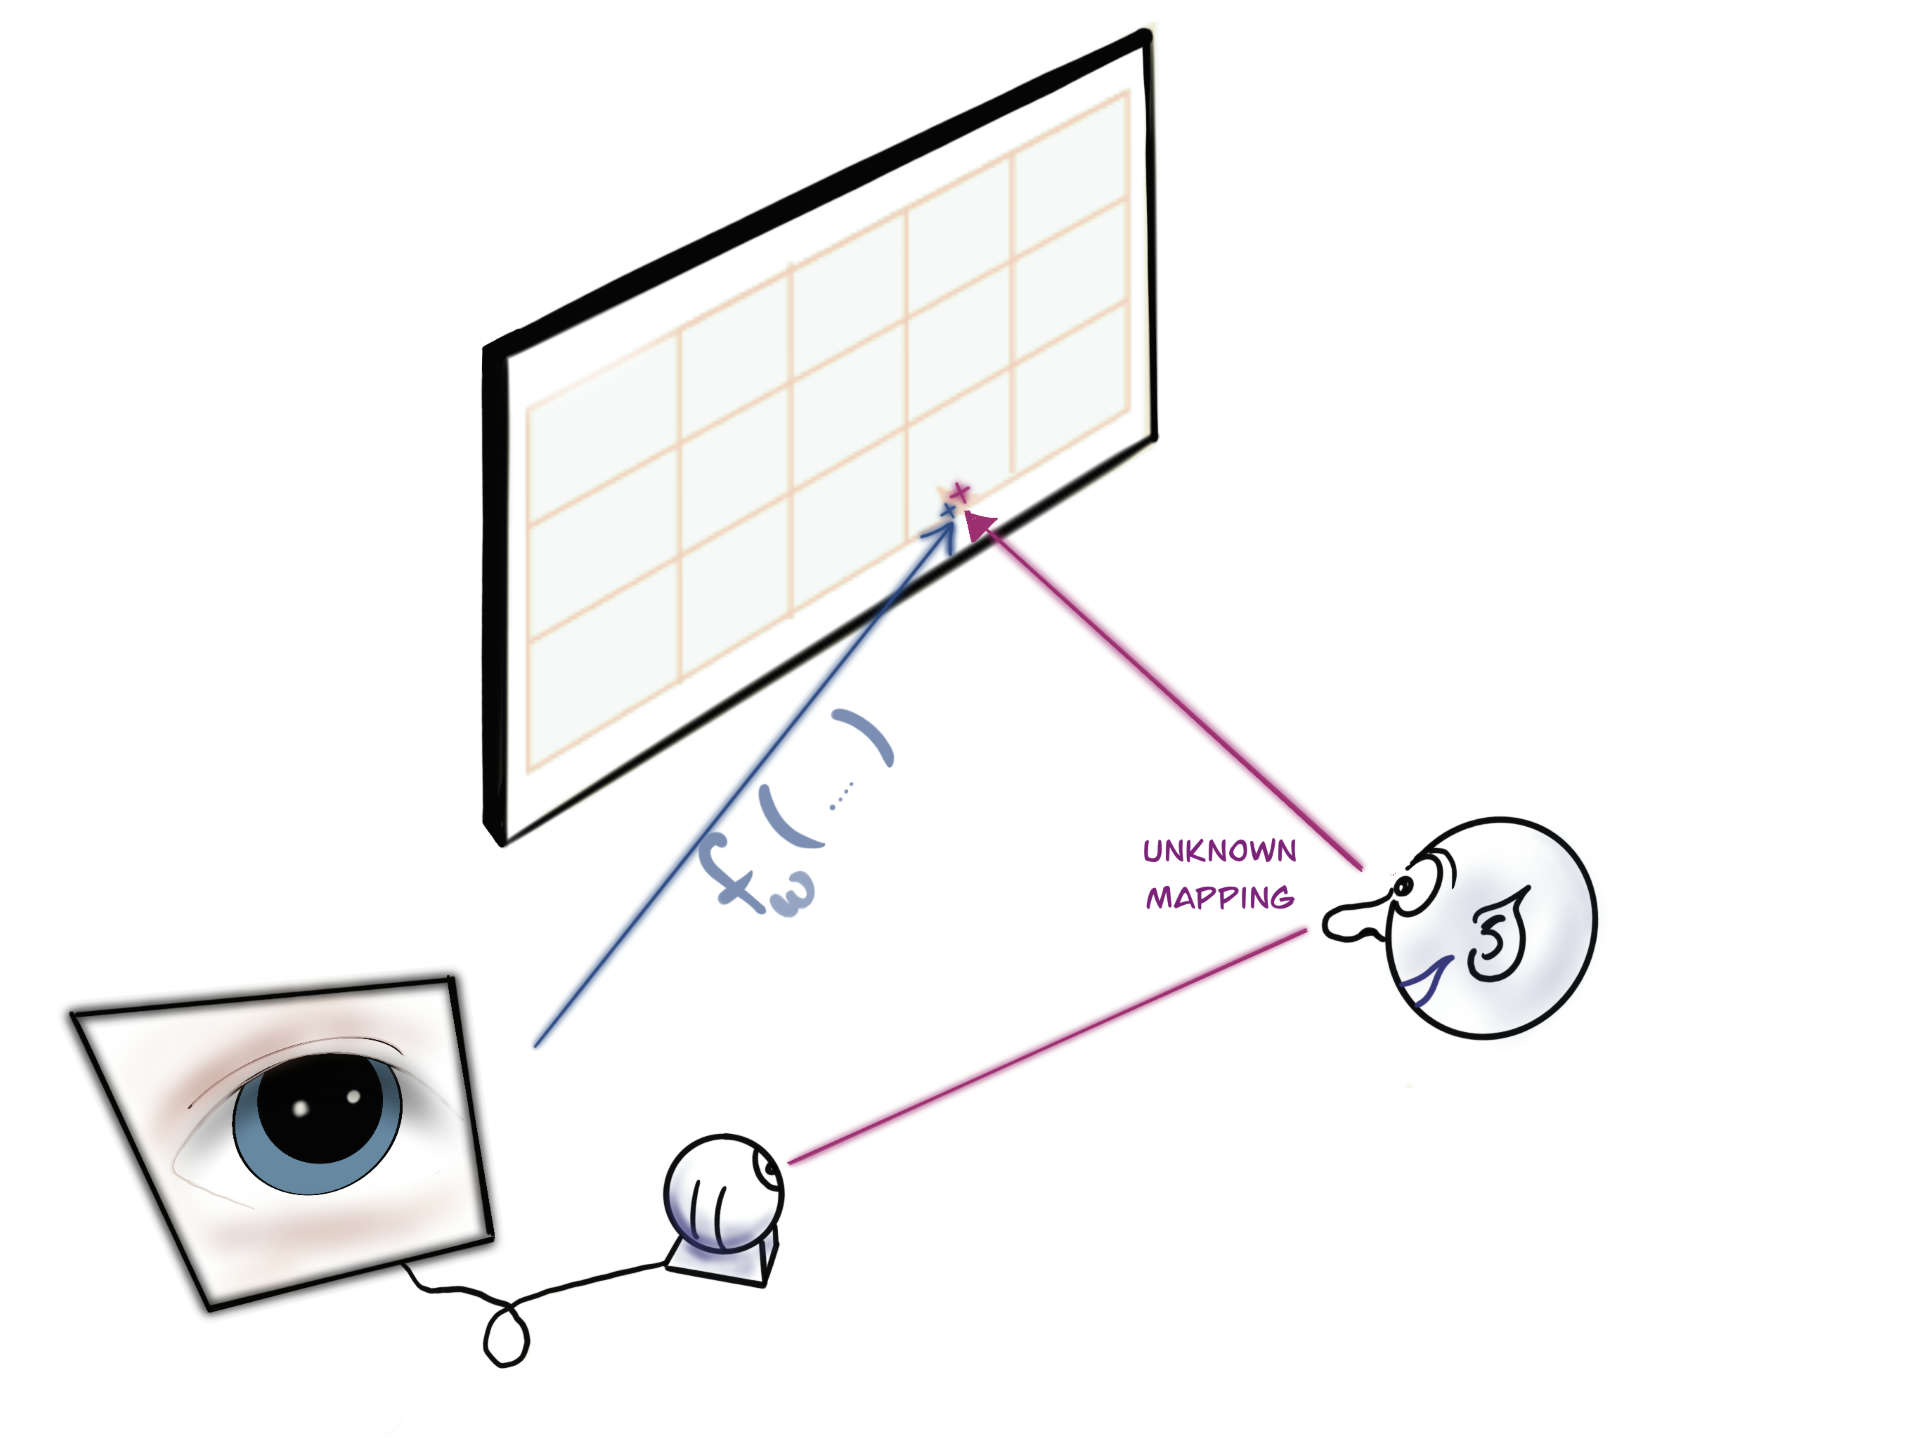

<figcaption class="figure-caption has-text-centered">Figure 2: Diagram of a gaze estimation system. The eye, which is directed at a specific point on
the screen is captured by the camera. The two red lines represent an unknown transformation from image
to eye and eye to screen. We learn this transformation directly which is shown as $f_{\mathbf{w} }(x, y)$ in the diagram.
</figcaption>
</figure>
</div>


</div>



</div>

### Gaze mapping function
The goal of this exercise is to estimate gaze from image sequences using a regression model. Define $f_{\mathbf{w}}(x, y)$ as the gaze  model which maps pupil positions $(x, y)$ to screen coordinates $(x', y')$. The model parameters $\mathbf{w}$ are learned from a training set containing paired pupil and screen positions. 
## Gaze estimation test subject 0
The first step is to train a gaze estimation model using the dataset of `test_person_0`
. You will:
- Train the models using the data `pupils_n_training`
 and `screen_coordinates_training`
. 
- Test the performance of the model using the `pupils_n_testing`
 and `screen_coordinates_testing`
. 

### Data and visualization

---
**Task 1 (easy): Data visualization👩‍💻**
1. Run the cell below to visualize the data of `test_subject_0`
.


---

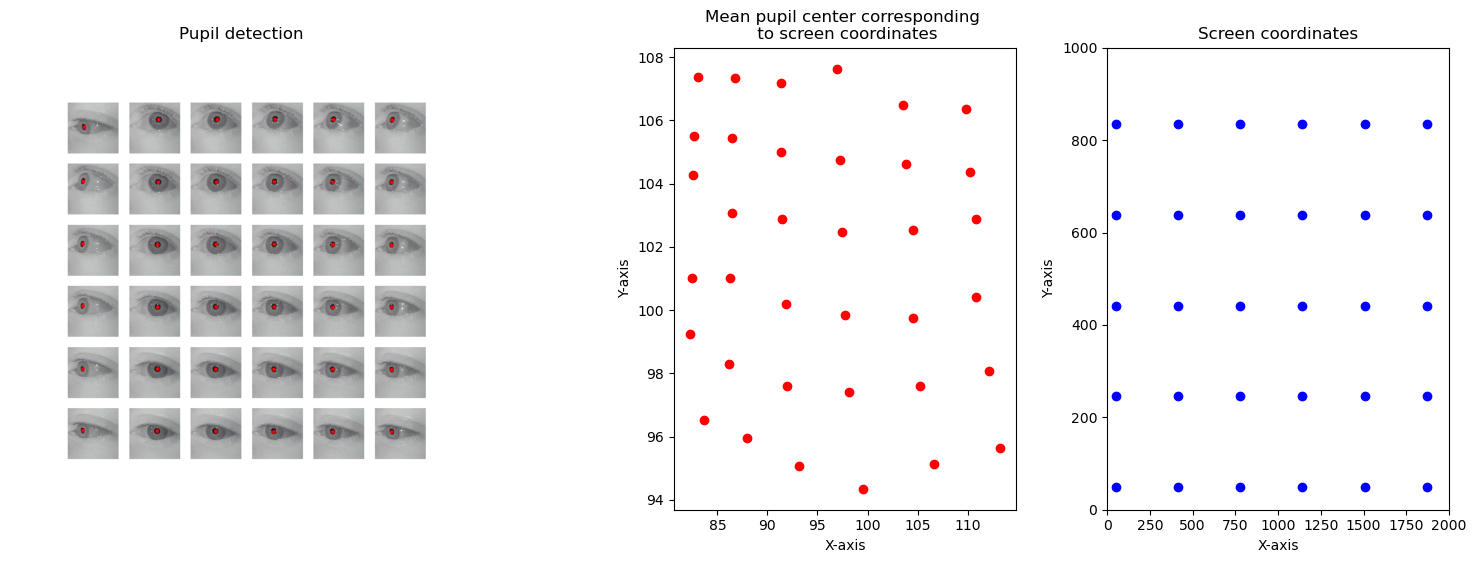

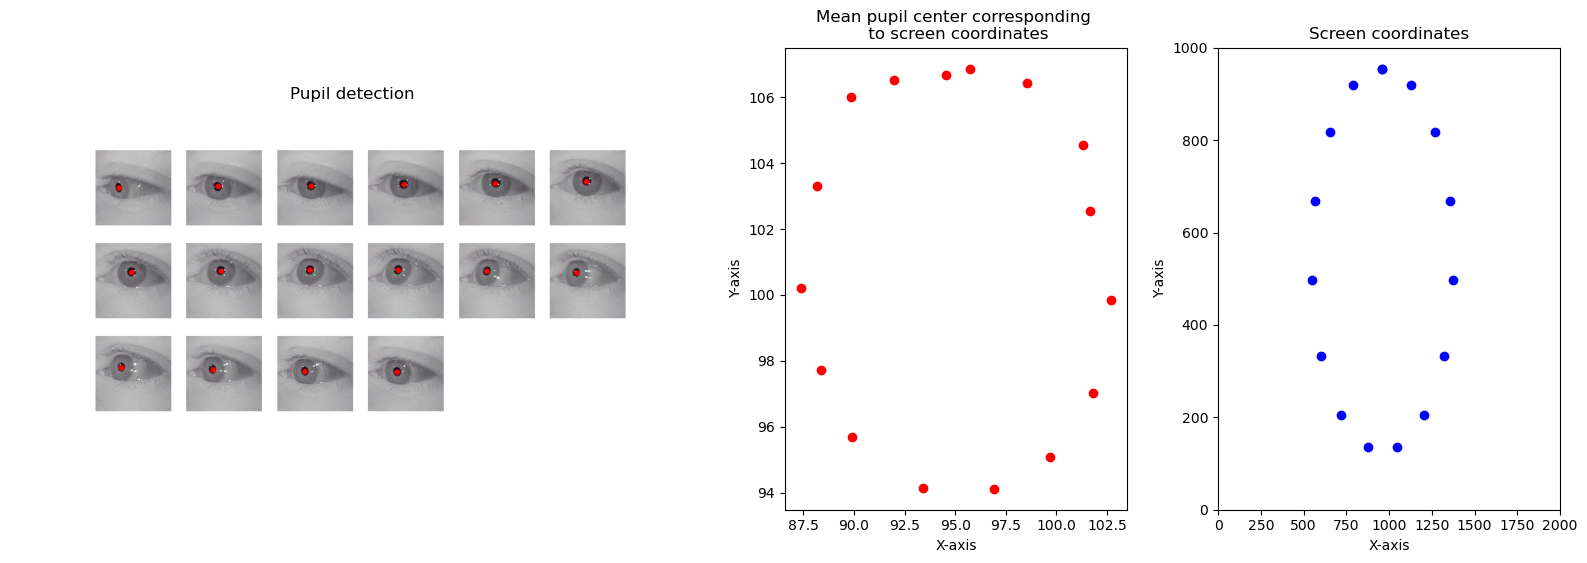

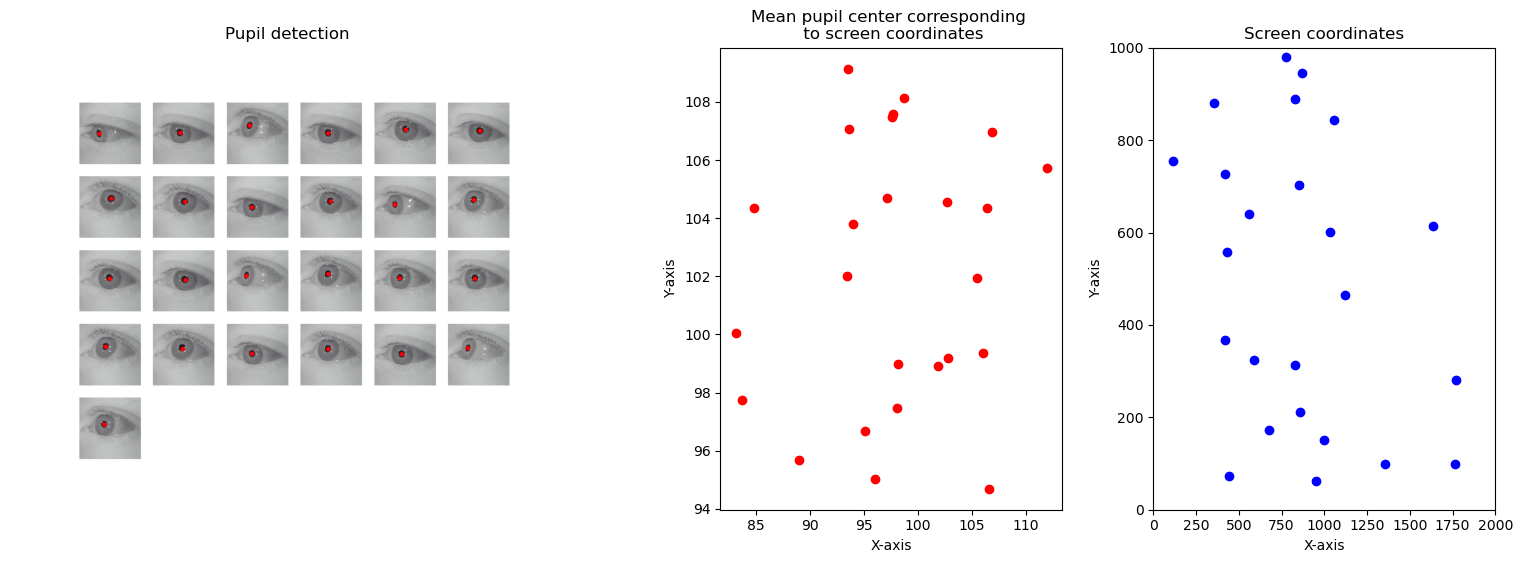

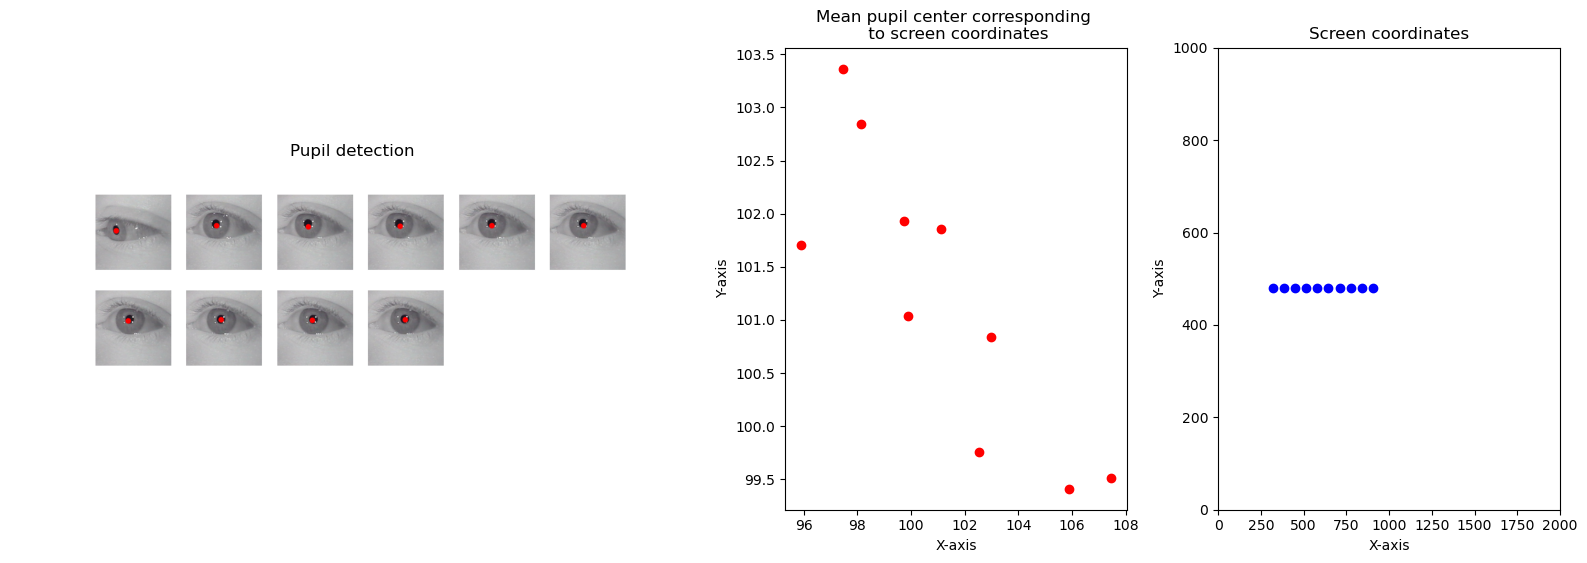

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import iml_util

D = iml_util.gen_data_subject_0()
for i in range(4):
    dataset = D[i]
    grid = iml_util.create_image_grid_viz(dataset)
    iml_util.image_and_scatter(grid, dataset)

## Implement a gaze estimation model
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div style="float: right; width: 25%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="gaze">

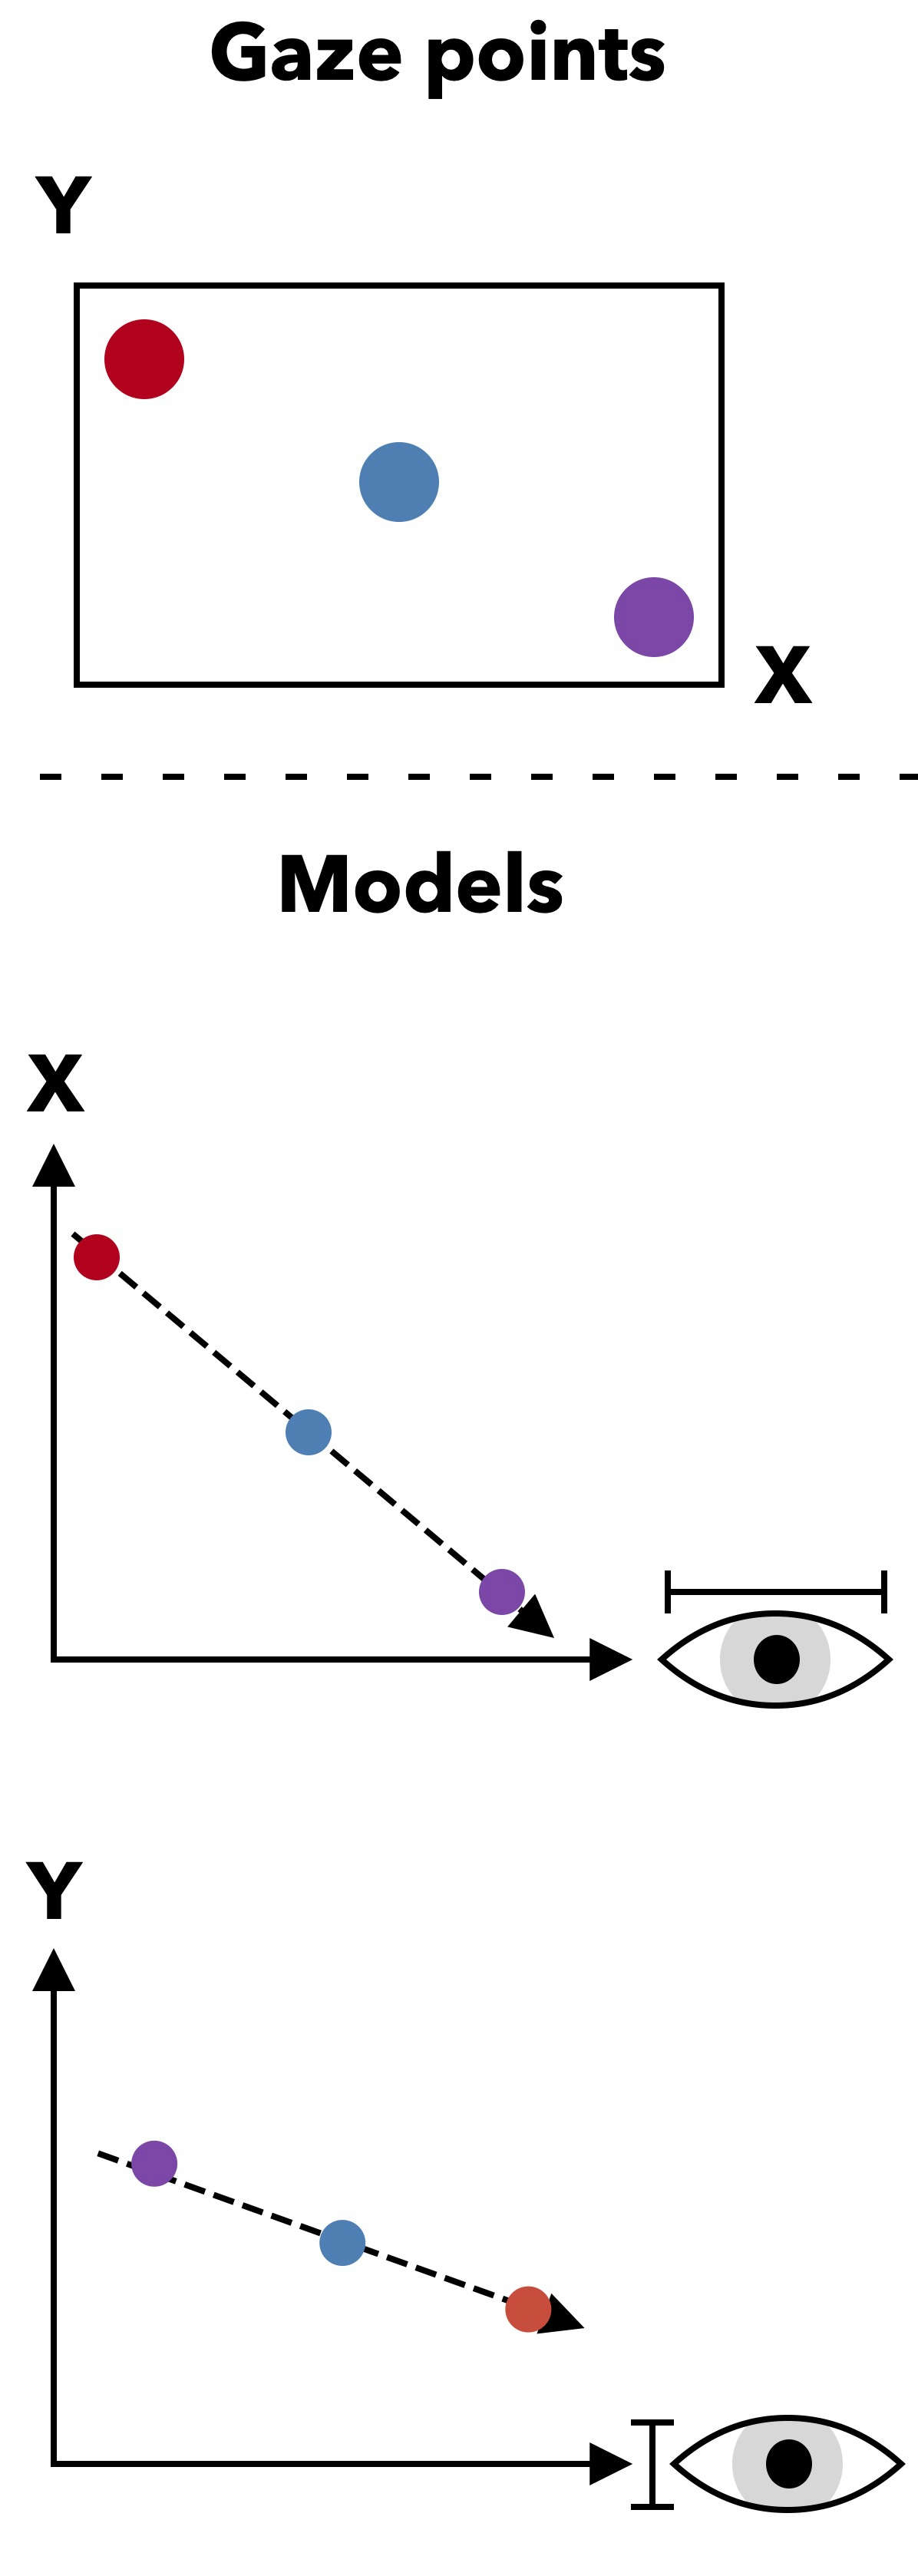

<figcaption class="figure-caption has-text-centered">Figure 3: Point mapping. Top: Three screen coordinates. Middle: Screen and eye $x$ coordinates for the same three points. Bottom: Screen and eye $y$ coordinates for the same three points.
</figcaption>
</figure>
</div>


</div>

<div style="float: left; width: 75%; justify-content: start" class="block is-clearfix">

The true nature of the function that transforms pupil positions to screen positions is not easy to model. Even when the head is stationary, the relationship between pupil position in the image and gaze is non-linear due to the pupil's movement along a spherical curve. For now, we'll approximate the gaze mapping by using a linear function. 
Since the goal is to predict a $2D$ screen coordinate from a $2D$ pupil coordinate, it's more straightforward to train two separate models for each coordinate by following the pattern of previous exercises. The linear gaze model can be expressed as:struct

$$
\begin{aligned}
x' &= ax + by + c\\
y' &= dx + ey + f.
\end{aligned}
$$
Gaze mappings is demonstrated in [Figure 3](#gaze) to the right. Here, the $x$ coordinate of the pupil maps to the $x$ coordinate on the screen. In the real model, we use both $x$ and $y$ as inputs to both models estimating the $x$ position and $y$ position on the screen.

**Hint**
Use the previous exercise
 as a guideline.

In the upcoming tasks, you will be guided through the process of identifying essential entities necessary for establishing the linear equations required to learn the model parameters of the given model. The gaze model is divided into two distinct regression models, denoted as $x' = f_{w_1}(x, y)$ and $y' = f_{w_2}(x, y)$, each associated with its unique set of model parameters $w_1$ and $w_2$. Essentially, one model predicts the value of $x'$, and the other model predicts the value of $y'$. Follow the steps outlined below for the model $x' = f_{w_1}(x, y) = ax + by + c$, and subsequently, replicate the same steps for $y'$.
1. Identify model parameters and inputs to the model. We recommended that you use Least Squares from the numpy library [linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)
, it is recommended due to numerical stability. 
2. Isolate the unknown model parameters and the known into the design matrix.
3. Setup the linear equations $Aw=b$, where $A$ is the design matrix, $w$ the unknown model parameters and $b$ contains labels.



</div>



</div>


---
**Task 2 (medium): Initial reflection💡**
1. Identify the model parameters, inputs and outputs for the model.
2. Identify and determine the minimim number of data points needed to fit the model.
3. Using the least amount of points required to fit the model, does it matter which points are used? Why? Why not? 


---


1. The model parameters consists of input points x_n,y_n and output points x'_n, y'_n, and the weights w_1 to w_6
2. For 6 unknowns we're going to need at least 6 points.
3. Yes, we do not want to use outliers as these are not (per definition) a representative part of the dataset. 



---
**Task 3 (medium): Implement a gaze model👩‍💻**
**Note:** You can choose to train two separate models, to predict each screen coordinate separately, or you can train one model predicting both coordinates simultaniously. It may be slightly simpler to use two separate models.

1. **Design matrix:** Implement a function `get_design_matrix`
 to create the design matrix from an array pupil positions.

2. **Calibration:** Complete the implementation of the function `calibrate`
 of the class `LinearGaze`
.
    - Use the `pupils_n_train`
 and `screen_coordinates_train`
 arrays as training data. 
    - Use the function `get_design_matrix`
 to create a design matrix from the pupil positions. 
    - Learn the parameters $\mathbf{w}$ from the dataset using Least Squares. 


3. **Gaze estimation:** Finish the implementation of the function `predict`
 of the class `LinearGaze`
 which predicts the gaze point given a pupil position using the learned model parameters. For reference, the affine model has the form $f_\mathbf{w}(x)=\mathbf{w}_0 x_0 + \mathbf{w}_1 x_1 + \mathbf{w}_2$. You may calculate the point for each coordinate seperately. Return the estimated screen coordinates using the models created during calibration.


**Note:** **Important!** Don't expect the affine model to perform particularly well. Expect the distances between true and predicted gaze points to vary by $\pm 200$ pixels.


---

In [3]:
def get_design_matrix(pupil_positions):
    """
    Constructs a design matrix.
    Parameters:
    pupil_positions (N x 2 numpy array): n samples, 2 features (px, py).
    
    Returns:
    design_matrix (N x 3 numpy array) : n_samples, 2 features + 1
    """
    # design_rows = [
    #     np.array([
    #         [x, y, 1, 0, 0, 0],
    #         [0, 0, 0, x, y, 1]
    #     ])
    #     for x, y in pupil_positions
    # ]
    
    design_rows = [
        np.array([
            [1, x, y, 0, 0, 0],
            [0, 0, 0, 1, x, y]
        ])
        for x, y in pupil_positions
    ]
    
    return np.vstack(design_rows)

def linear(param, x):
    return param[0] + param[1]*x[0] + param[2]*x[1]

def linear2(param, x):
    return  param[0]*x[0] + param[1]*x[1] + param[2]

class GazeModel:
    def calibrate(self, dataset):
        ...

    def predict(self, pupil):
        ...

    def predict_many(self, pupils):
        return np.array([self.predict(pupil) for pupil in pupils])


class LinearGaze(GazeModel):
    def calibrate(self, dataset, pupil_training_set, screen_training_set):
        """
        Calibrates the LinearGaze model by fitting two linear regression models for x and y coordinates based 
        on the training dataset.

        Parameters:
            dataset (dict): The dictionary D containing the training data with two keys:
                - "pupils_train" (N x 2 numpy array): n samples, 2 features (px, py) representing pupil 
                  positions.
                - "positions_train" (N x 2 numpy array): n samples, 2 features (screen coordinate x, screen coordinates y) representing
                  the true gaze positions being the screen coordinates.

        Returns:
            None: Updates the model's parameters (self.model_x, self.model_y) based on 
            the least squares solution for x and y positions.
        """

        pupil_data = dataset[pupil_training_set]
        selected_points = np.array(pupil_data)
        design = get_design_matrix(selected_points)

        screen_coordinates = dataset[screen_training_set]
        selected_screencoords = np.array(screen_coordinates).reshape(-1, 1)

        weights,_,_,_ = np.linalg.lstsq(design, selected_screencoords)
        model_x = np.array(weights[:3]).flatten()
        model_y = np.array(weights[3:6]).flatten()
        #print(weights)
        #print(model_x)
        #print(model_y)
        #print(pupil_data)
        #print(screen_coordinates)
        self.model_x = model_x
        self.model_y = model_y

        return model_x,model_y


    def predict(self, pupil):
        """
        Predicts the gaze position (x, y) based on the given pupil position using the calibrated model.

        Parameters:
            pupil (1 x 2 numpy array): 2 features (px, py) representing the current pupil position.

        Returns:
            x, y (float, float): Predicted gaze position (x, y) based on the linear model.
        """
        # Write your implementation
        return [linear(self.model_x, pupil), linear(self.model_y, pupil)]



---
**Task 4 (medium): Model evaluation👩‍💻💡**
The following task is about evaluating the performance of your models. In the following task you will complete the function `results_for_model`
. It is important that the results are calculated for the complete dataset of `test_subject_0`
 (all of $\mathcal{D}_{p0}, \mathcal{D}_{p1}, \mathcal{D}_{p2}, \mathcal{D}_{p3}$ as one dataset).
1. Finish the implementation of the function `results_for_model`
. For each dataset it must:    - **Calculate prediction errors:**         - Calculate:            - The _absolute error_ between each prediction and true gaze.
            - The _mean Eucledian distance_ between the true values and the predictions.
            - The _root-mean-square error_ (_rmse_) between the true values and the predictions.
            - The _mean absolute error_ (_mae_) as well.








---

In [4]:
import math

def shit(
        results, 
        model, 
        dataset_test, 
        pik, 
        pupil_test_set, 
        screen_test_set):
    test = dataset_test[pik]
    results[pik] = {}
    predicted = model.predict_many(test[pupil_test_set])
    ground_truth = test[screen_test_set]
    results[pik]["predicted"] = predicted
    results[pik]["ground_truth"] = ground_truth
    results[pik]["model_x"] = model.model_x
    results[pik]["model_y"] = model.model_y

    errors = predicted - ground_truth
    absolute_errors = np.abs(errors)
    results[pik]["errors"] = absolute_errors

    squared_errors = errors**2
    results[pik]["rmse"] = np.sqrt(np.mean(squared_errors))

    euclidean_distance = np.sqrt(np.sum(squared_errors, axis=1))
    results[pik]["dist"] = np.mean(euclidean_distance)
    results[pik]["mae"] = np.mean(absolute_errors, axis=0) 


def results_for_model_pick(model, dataset_train, dataset_test, pupil_training_set, screen_training_set, pupil_test_set, screen_test_set, d_max, pik):
    """
    Evaluates the performance of the model across multiple datasets and computes prediction errors.

    Parameters:
        model (object): A gaze model object.
        d_max (int, optional): Maximum number of patterns of a dataset to evaluate. Default is 4.

    Returns:
        results (dict): A dictionary where each key corresponds to a dataset index (0 to d_max-1), and each value is a dictionary containing:
            - "predicted" (1 x N numpy array): The predicted values
            - "ground_truth" (1 x N numpy array): The corresponding ground truth values to the predicted
            - "model_x" (list): List of model paramters for model x 
            - "model_y" (list): List of model paramters for model y 
            - "errors" (N x 2 numpy array): Absolute errors between predicted and ground truth positions (x, y).
            - "rmse" (float): Root Mean Squared Error (RMSE) for the predictions across the dataset.
            - "dist" (float): Mean Euclidean distance between the predicted and actual positions.
            - "mae" (1 x 2 numpy array): Mean absolute error in x and y dimensions.
    """

    model_x, model_y = model.calibrate(dataset_train[pik], pupil_training_set, screen_training_set)
    #predicted = model.predict_many(dataset_test[pik][pupil_test_set])

    results = {}
    for d in range(d_max):
        shit(results, model, dataset_test, d, pupil_test_set, screen_test_set)


    # Write your solution here
    return results
    



def results_for_model(model, dataset_train, dataset_test, pupil_training_set, screen_training_set, pupil_test_set, screen_test_set, d_max):
    """
    Evaluates the performance of the model across multiple datasets and computes prediction errors.

    Parameters:
        model (object): A gaze model object.
        d_max (int, optional): Maximum number of patterns of a dataset to evaluate. Default is 4.

    Returns:
        results (dict): A dictionary where each key corresponds to a dataset index (0 to d_max-1), and each value is a dictionary containing:
            - "predicted" (1 x N numpy array): The predicted values
            - "ground_truth" (1 x N numpy array): The corresponding ground truth values to the predicted
            - "model_x" (list): List of model paramters for model x 
            - "model_y" (list): List of model paramters for model y 
            - "errors" (N x 2 numpy array): Absolute errors between predicted and ground truth positions (x, y).
            - "rmse" (float): Root Mean Squared Error (RMSE) for the predictions across the dataset.
            - "dist" (float): Mean Euclidean distance between the predicted and actual positions.
            - "mae" (1 x 2 numpy array): Mean absolute error in x and y dimensions.
    """


    results = {}
    for d in range(d_max):
        train = dataset_train[d]
        test = dataset_test[d]
        results[d] = {}
        model_x, model_y = model.calibrate(train, pupil_training_set, screen_training_set)
        predicted = model.predict_many(test[pupil_test_set])
        ground_truth = test[screen_test_set]
        results[d]["predicted"] = predicted
        results[d]["ground_truth"] = ground_truth
        results[d]["model_x"] = model_x
        results[d]["model_y"] = model_y

        errors = predicted - ground_truth
        absolute_errors = np.abs(errors)
        results[d]["errors"] = absolute_errors

        squared_errors = errors**2
        results[d]["rmse"] = np.sqrt(np.mean(squared_errors))

        euclidean_distance = np.sqrt(np.sum(squared_errors, axis=1))
        results[d]["dist"] = np.mean(euclidean_distance)
        results[d]["mae"] = np.mean(absolute_errors, axis=0) 

    # Write your solution here
    return results
    

 
results_linear = results_for_model(LinearGaze(), D, D,  'pupils_n_train', 'screen_coordinates_train', 'pupils_n_test', 'screen_coordinates_test', 4)

/var/folders/6b/btsgzmt15cs3kr5rhn7ypmy00000gn/T/ipykernel_46349/1267258917.py:70: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights,_,_,_ = np.linalg.lstsq(design, selected_screencoords)


Below you find a cell containing a function for visualizing the performance of the model. 

---
**Task 5 (medium): Visualize performance of your model👩‍💻**
1. **Create visualizations:** Run the cell below to visualiz the performance of the model for all patterns using the function `plot_results_grid`
 from `iml_util.py`
. The function takes a dictionary of results as well as the number of patterns in the dictionary. Combined they provide an overview of the nature of the error across the two dimensions.


---

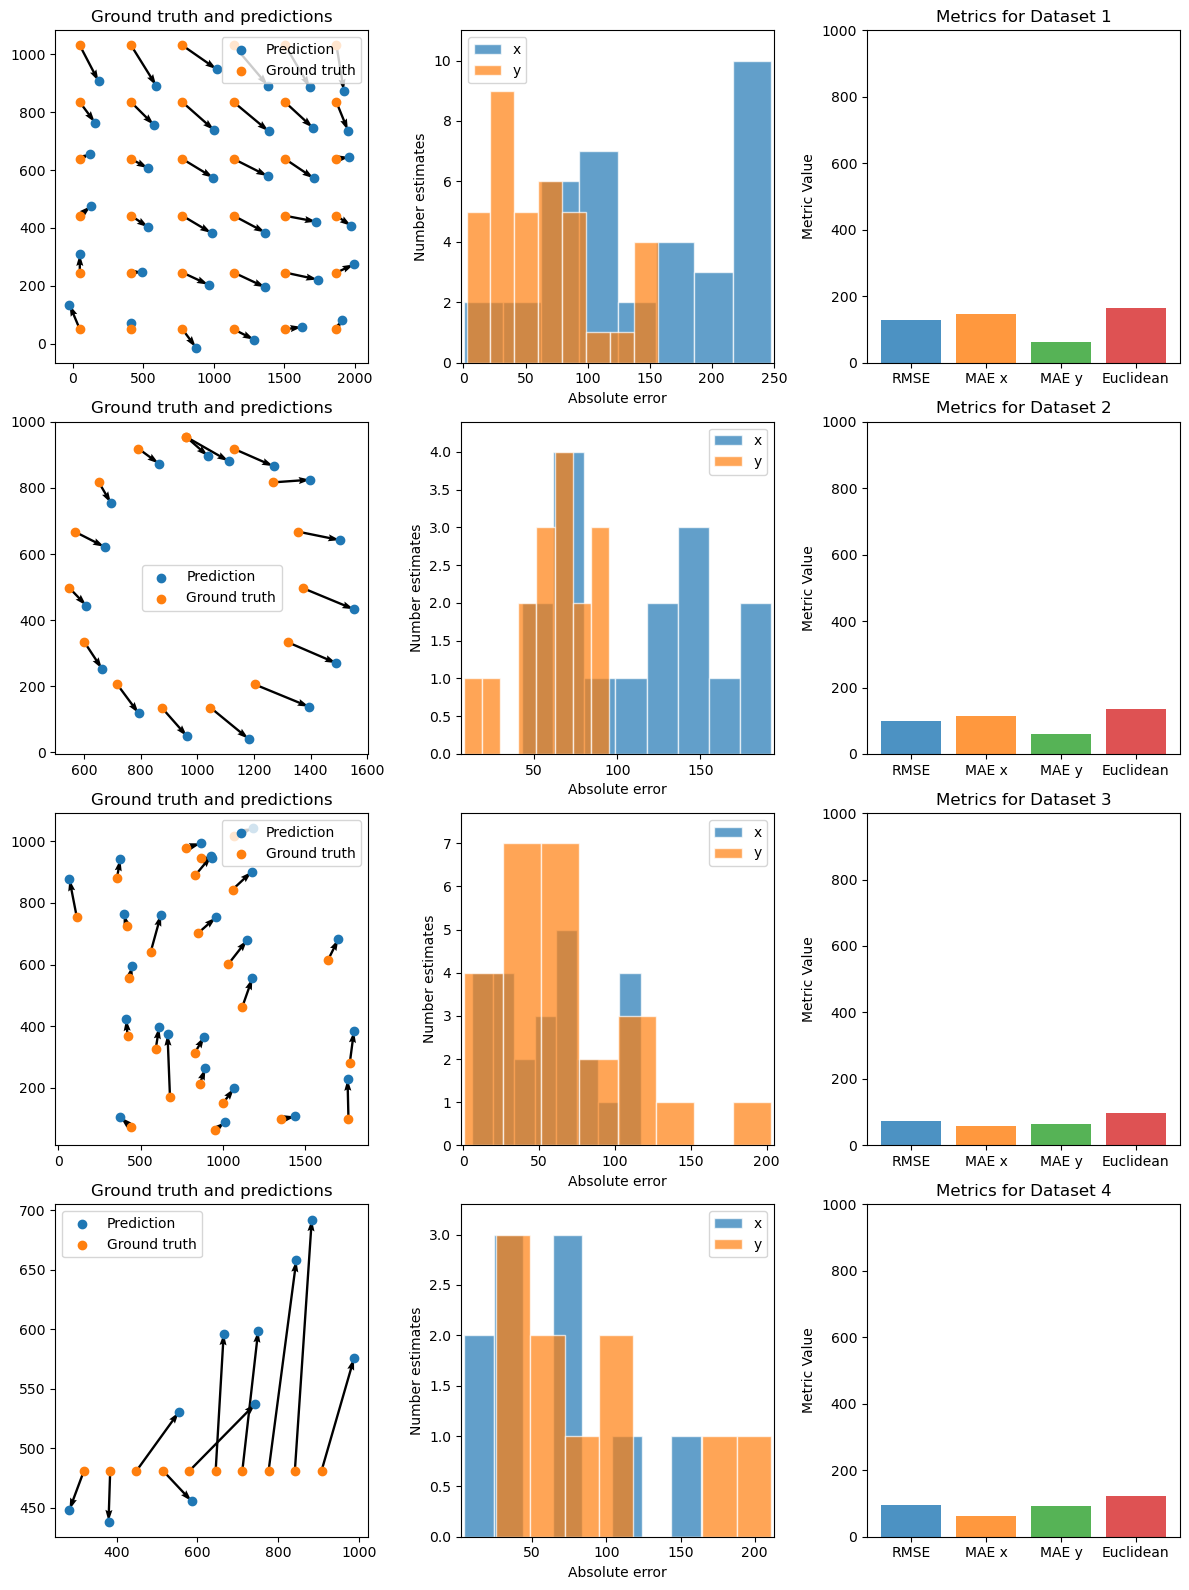

In [5]:
iml_util.plot_results_grid(results_linear, 4)


---
**Task 6 (medium): Evaluate performance of your model💡**
1. Evaluate the usefulness of the _mae_ or _rmse_ and their differences.
2. Identify at least 3 potential sources of error associated with the current affine model. Describe how each source of error contributes to the prediction error.


---

#Write your reflection here...
1. RMSE gives insight to the average magnitude of errors (so how wrong are we, when we are wrong), whereas MAE gives insight into what the average error is for a given prediction (how wrong are we in general). 
2. 
- Affine models are not geared to handle perspective changes very well, as affine models preserve parallel lines and relative scaling, therefore drastic changes in perspective in the training data, might lead to imprecise predictions.
- The location of the Fovea is unknown, so when we train it on an individuals data, this causes the model to be less generalizable for other test subjects, as the location of the Fovea varies for each person. 
- Noise in the images can cause small errors in the detection of the pupil and the pupil center. 

You have now went through the first part of the assignment processing the session of `test_subject_0`
. The remaining part of the assignment use the same approach as you have just gone through with the purpose of you working with and reflecting on the use of your own data collected. 
## Test on test subject 1
In the data processing exercise Data preprocessing
 the pupil corrdinates `mean_pupil_coordinates.csv`
 and the corresponding screen coordinates `screen_coordinates.csv`
 were saved in the in the folder with the test subjects and patterns. Recall the four calibration patterns used for the data collection being **grid**, **circle**, **line** and **random**.
In this exercise you will use the calibration (training data) of `test_subject_0`
 on the data from `test_subject_1`
 and visualized in [Figure 4](#calibration).
<div style="float: none; width: 100%; justify-content: start" class="block is-clearfix">

<div class="has-text-centered">
<figure class="image is-inline-block" id="calibration">

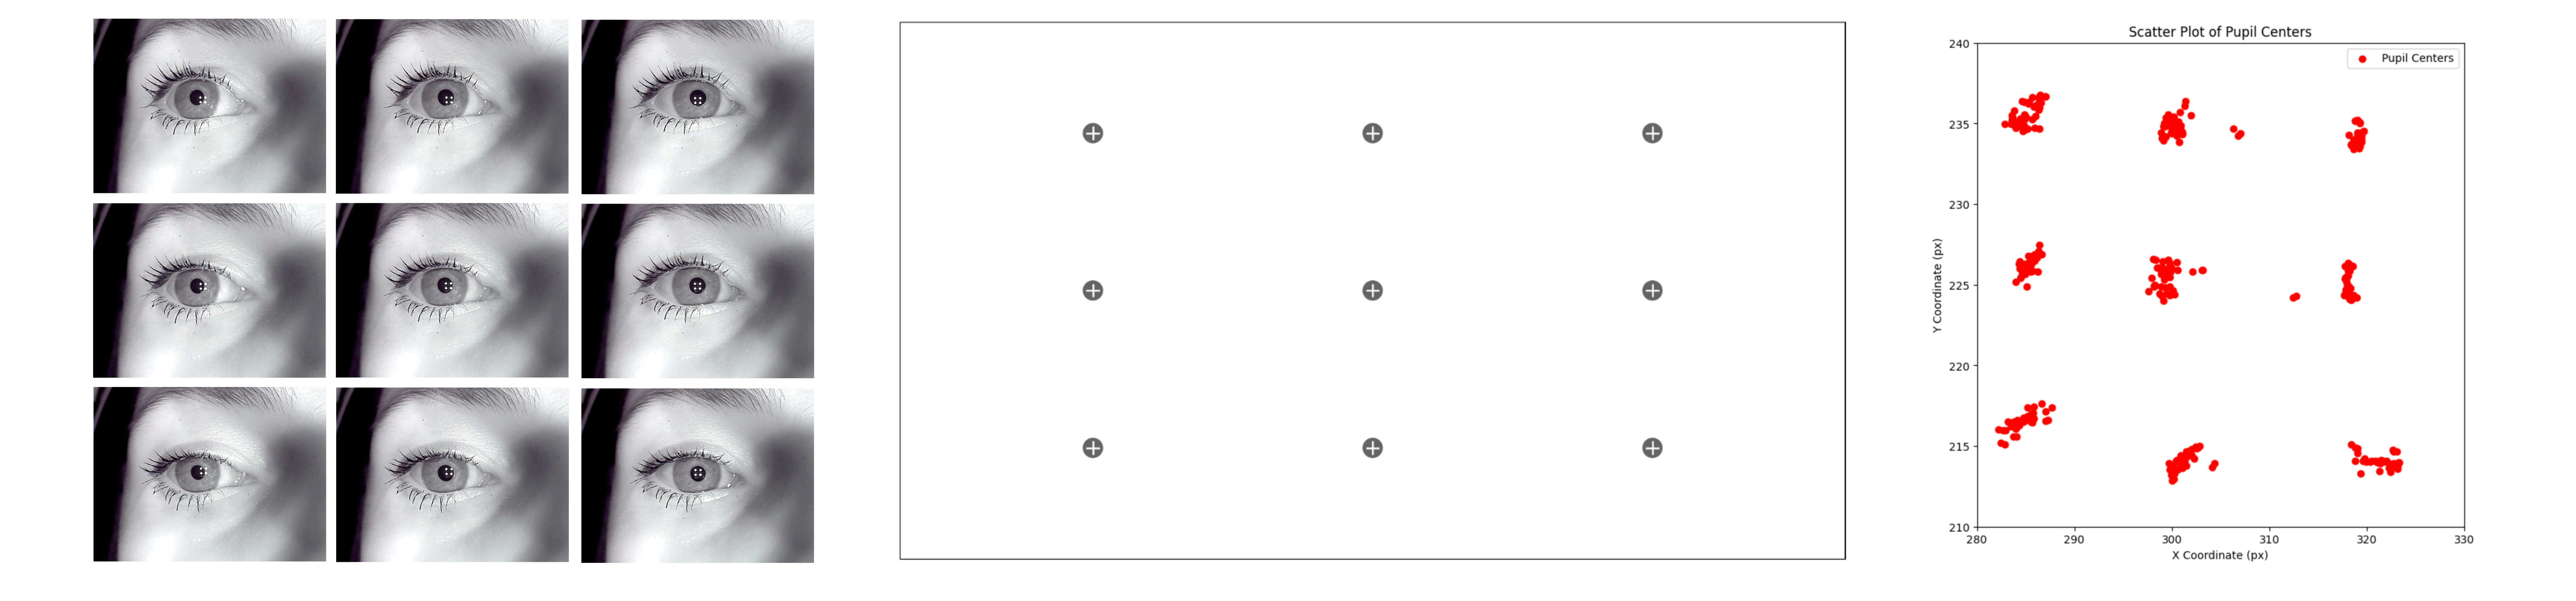

<figcaption class="figure-caption has-text-centered">Figure 4: Left: Images from calibration pattern grid. Middle: Calibration pattern. Right: Pupil center scatterplot from calibration pattern grid.</figcaption>
</figure>
</div>


</div>


---
**Task 7 (easy): Load the data👩‍💻**
1. Run the cell below to load the data of `test_subject_1`
. _Similarily_ to the data of `test_subject_0`
 meaning that the `grid`
 pattern is defined as training set for all other patterns. The data is stored as a list of dictionaries in the following order: `grid`
, `circle`
, `line`
, and `random`
. Within each dictionary you find: 


**Details about the data format of `test_subject_1`**
**Dataset elements:**
- `pupils_train`
: Mean pupil positions for the 9 calibration points from `grid`
 pattern (an $9 \times 2$ array containing the x and y coordinates (`px`
, `py`
)).
- `screen_coordinates_train`
: Screen target positions for the 9 calibration points from `grid`
pattern ($9 \times 2$ array containing x,y pixel position for the target on the screen (`sx`
, `sy`
)).
- `pupils_test`
: Mean pupil positions for the calibration points for the pattern accociated as the key(an $N \times 2$ array containing the $N$ x and y coordinates (`px`
, `py`
)).
- `screen_coordinates_train`
: Screen target positions for the N calibration points associated to the pattern defined as the key ($N \times 2$ array containing the $N$ x andy pixel positions for the target on the screen (`sx`
, `sy`
))



---

In [6]:
test_subject = 'test_subject_1'
trial = '20250901_T0'
D3 = iml_util.gen_data_subject(test_subject, trial)


---
**Task 8 (easy): Visualize performance👩‍💻**
1. Run the cell below to evaluate the gaze estimation model using the data from `test_subject_1`



---

/var/folders/6b/btsgzmt15cs3kr5rhn7ypmy00000gn/T/ipykernel_46349/1267258917.py:70: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights,_,_,_ = np.linalg.lstsq(design, selected_screencoords)


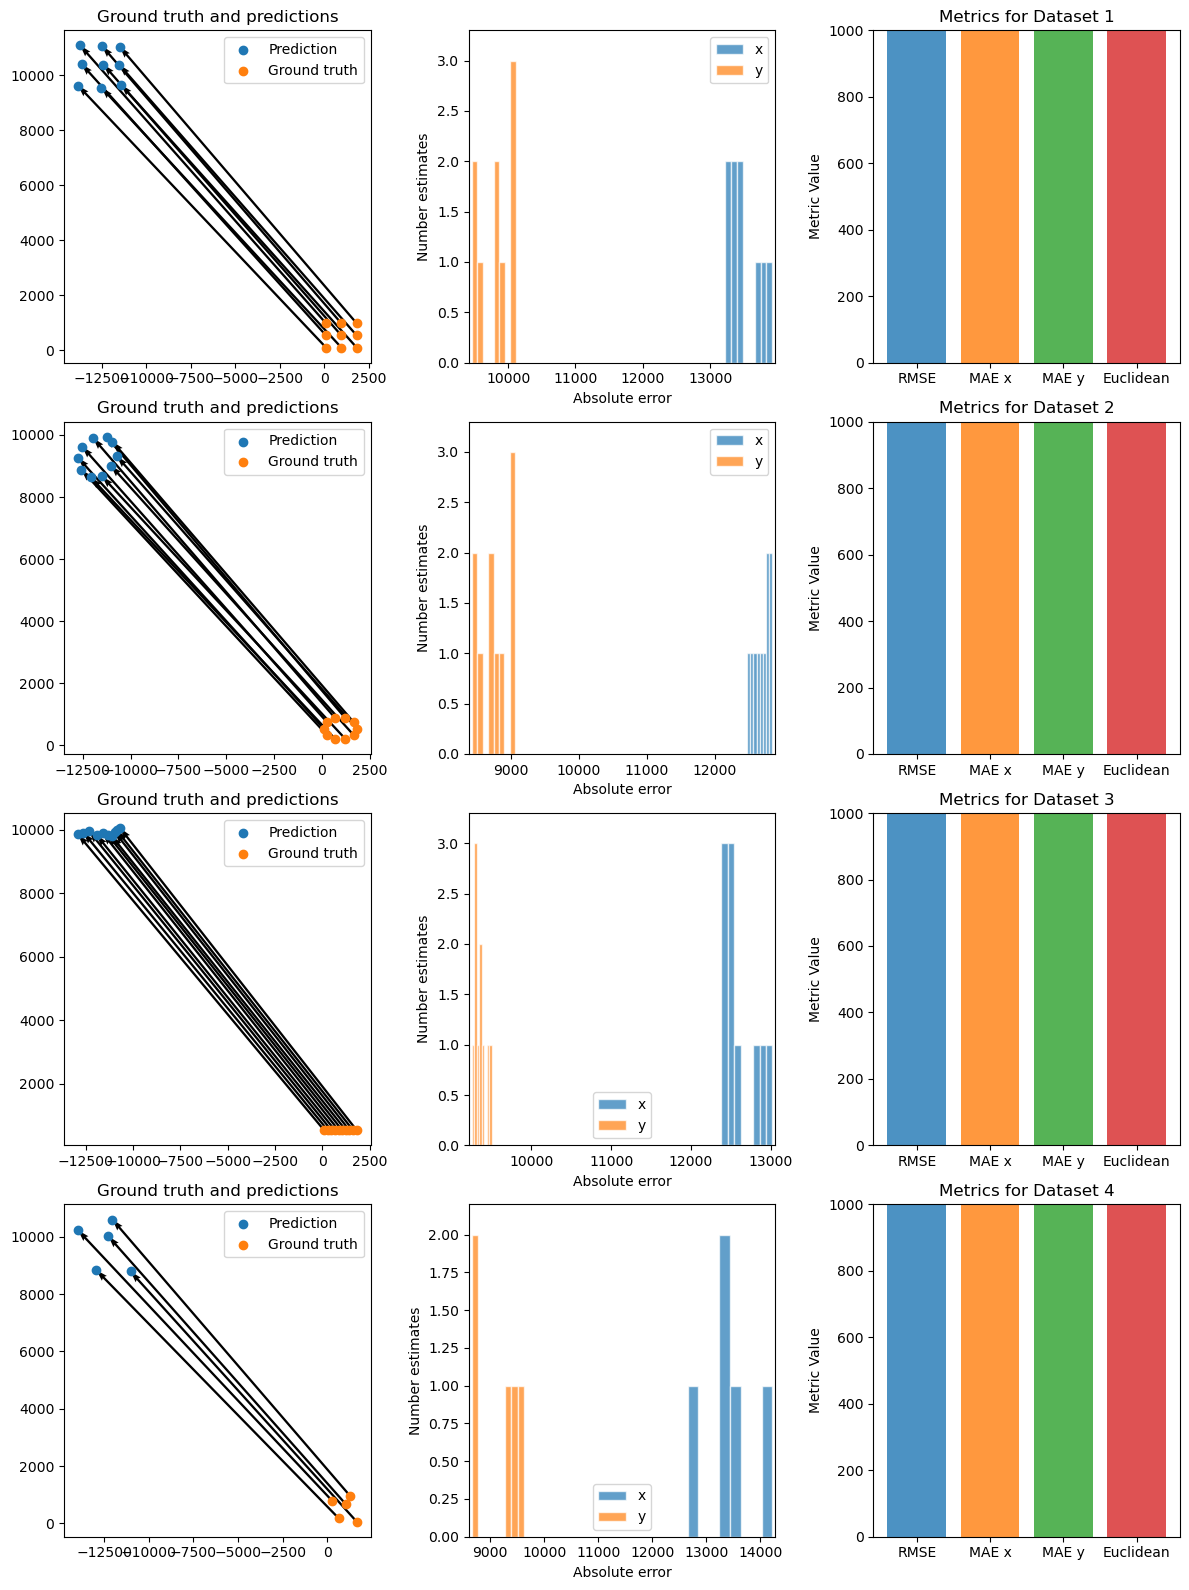

In [7]:
results_linear_ts3 = results_for_model(LinearGaze(), D, D3, 'pupils_n_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4)

iml_util.plot_results_grid(results_linear_ts3, 4)


---
**Task 9 (medium): Evaluation♾️💡**
You likely have observed larger prediction errors, including the `MAE_y`
 and `RMSE`
. Reflect on:
1. How well does the model generalize?
2. Use your reflections in Task 8 in the exercise Data preprocessing
 to elaborate on the results in this exercise.
3. Comment on differences between the predicted `x`
 and `y`
 coordinate.


---

#Write your reflections here...
1. As can be seen in the plots and the very large RMSE, MAE x, MAE y values, the model does not generalize very well. 
2. Because the setups used for each test subject is so different, the input data  (pupil coordinates) for each subject might differ from one another (observed by visual inspection of videos of each test subject). Therefore training the model on one test subject, and testing this model on another subject, causes large errors (i.e does not generalize well).
3. We can see that the absolute error for the y coordinate is smaller compared to the absolute error for the x coordinate. The reason for this might be that the eye is more stable on the y-axis, whilst moving more on the x-axis. This results in less variance in the y-axis than the x-axis. 

## Gaze estimation test subject 1
In this the gaze estimation model is trained using the `grid`
 pattern of `test_subject_1`
, and test it on the patterns. 

---
**Task 10 (easy): Train and test a model👩‍💻**
1. Use `result_for_model`
 to train and test a gaze estimation model based on `test_subject_1`
.
2. Use `plot_results_grid`
 to visualize the result.

**Note:** The result using pupil centers from the `grid`
 pattern is a result of training and testing on the same data.


---

/var/folders/6b/btsgzmt15cs3kr5rhn7ypmy00000gn/T/ipykernel_46349/1267258917.py:70: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights,_,_,_ = np.linalg.lstsq(design, selected_screencoords)


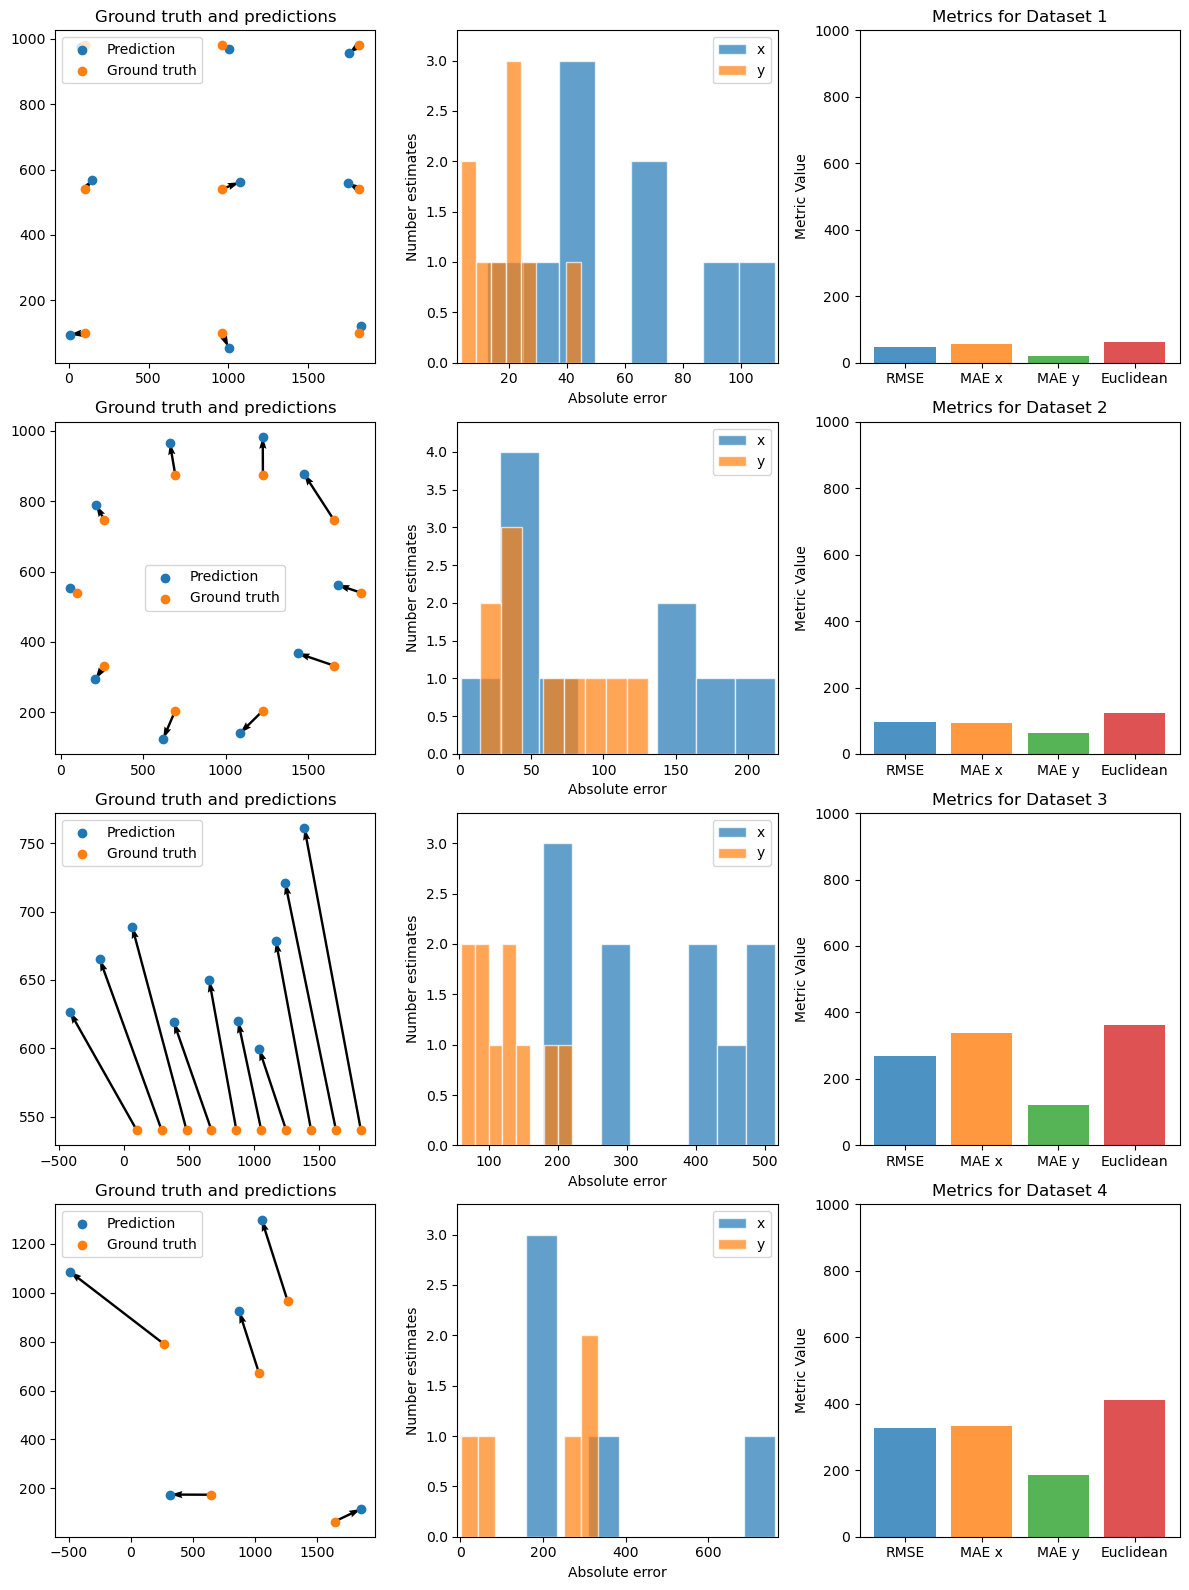

In [17]:
# We created our own method to be able to train on a single pattern but test on all patterns
results_linear_ts3_better = results_for_model_pick(LinearGaze(), D3, D3, 'pupils_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4, 0)

iml_util.plot_results_grid(results_linear_ts3_better, 4)



---
**Task 11 (easy): Evaluation💡**
1. Reflect on the result testing the model on `test_subject_1`
.     - Use your reflection from Task 8 in exercise Data preprocessing
 to elaborate on the result.        - Why does the performance of the model trained on `test_subject_1`
 show significantly larger prediction errors compared to the one trained **and** tested on `test_subject_0`
?






---

#Write your reflections here...
1. On test subject 0 we train on all patterns while on test subject 1 we train on a single pattern this means that for test subject 1 the model performs well on the pattern it was trained on (grid) but fails to generalize on other patterns(random/line), while remaining accurate similar patterns (circle).



Until now the models have been trained using the nine calibration points from the `grid`
 pattern. You will now increase the amount of training data by incoorporating all patterns except `circle`
. The pattern `circle`
 will be used for testing. In the cell below a dictionary `D3_mod`
 contains the training and test data similar to the structure of `D`
and `D3`
. . 

---
**Task 12 (medium): Adding more data♾️💡**
1. Use the function`results_for_model`
 and the `LinearGaze`
 class to train a new model using `D3_mod`
. Use `plot_results_grid`
 to visualize the results and the function `plot_from_results_dict`
 to visualize the models.
2. Run the cell below to train and test the model and visualize the result. 


---

/var/folders/6b/btsgzmt15cs3kr5rhn7ypmy00000gn/T/ipykernel_46349/1267258917.py:70: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights,_,_,_ = np.linalg.lstsq(design, selected_screencoords)


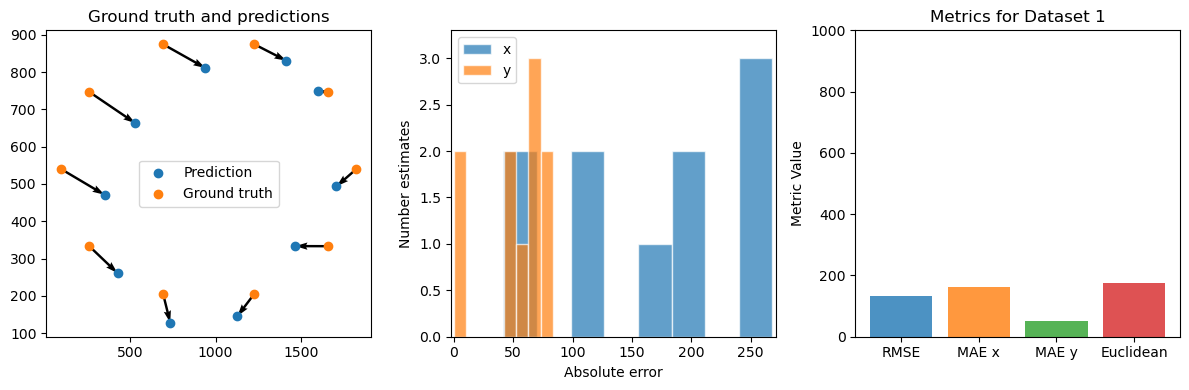

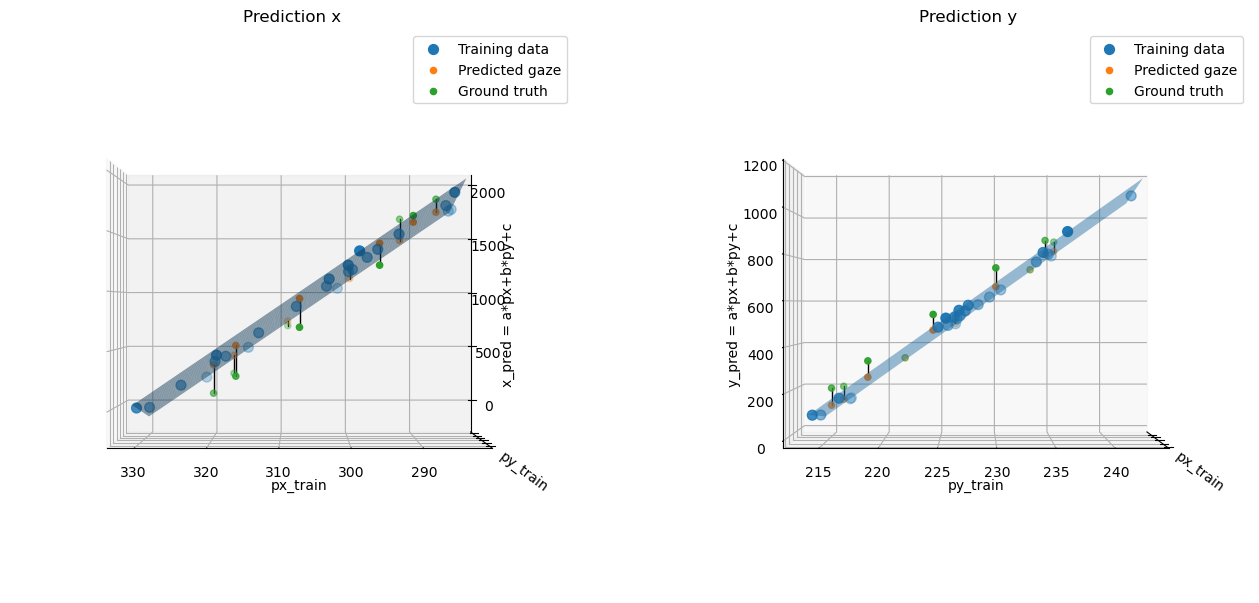

In [9]:
D3_mod = {}

ts3_p_train = D3[0]['pupils_test']
ts3_s_train = D3[0]['screen_coordinates_test'] 

ts3_p_test = D3[1]['pupils_test']
ts3_s_test = D3[1]['screen_coordinates_test']

for i in range(2,4):
    ts3_p_train = np.vstack((ts3_p_train,D3[i]['pupils_test']))
    ts3_s_train = np.vstack((ts3_s_train,D3[i]['screen_coordinates_test']))
    
D3_mod['pupils_train'] = ts3_p_train
D3_mod['screen_coordinates_train'] = ts3_s_train
D3_mod['pupils_test'] = ts3_p_test
D3_mod['screen_coordinates_test'] = ts3_s_test

D3_mod = [D3_mod]

# Write your code here
results_linear_ts3_more_data = results_for_model(LinearGaze(), D3_mod, D3_mod, 'pupils_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 1)

iml_util.plot_results_grid(results_linear_ts3_more_data, 1)

# !!!!!! Denne her funktion virker kun nu fordi vi manuelt har været inde og rette i iml_util for at grafen følger vores eget format med
# param[0]*x+param[1]*y+param[2]. Det har vi hardcoded ind i iml_util pga måden vi har implementeret vores model (i linear2 function)
# Det virker meget forkert at vi skal rette noget i iml_util for at få det til at virke, så tror vi skal have lavet resten af opgaven om
# sådan så vi bruger den originale kode for linear 
iml_util.plot_from_results_dict(results_linear_ts3_more_data[0], D3_mod[0])


---
**Task 13 (medium): Evaluate♾️💡**
1. How does adding more training data affect the results.    - Does increasing the amount of training data _always_ improve the model's accuracy?
    - How does the variability in the data affect the model's ability to generalize when more data is added (elaborate on your reflection from Task 2.3)?
    - How could adding more data influence the optimization of the model parameters?




---

1. It depends on the data (shit in shit out), if more quality data is available (given that we still have enough data for testing), it does not hurt to train it on more data as that can improve the accuracy of the model and its parameters.
    - The variability in the data does affect the models ability to generalize, it is good that we have different patterns to train on. It might become difficult to discern what is an outlier and what is a different pattern. Thus we still need to ensure that the individual pattern does not contain significantly skewed data.

## Individual dataset
The pipeline of collecting data, training a model, testing, and evaluating it has been introduced. In this task, the data of your eyes will be used to train a model. Use the evaluation tools introduced in the assignment.

---
**Task 14 (easy): Individual dataset**
1. For reproduceability, write the _threshold_, _x_margin_, _y_margin_ and _side_ values that was used in the processing your data in Task 4 of the  Data preprocessing
 exercise.


---

In [11]:
#Note the values here
# Threshold = 55
# x_top = 230
# y_top = 280 (260 for grid)
# x_bottom = 330
# y_bottom = 330


---
**Task 15 (medium): Train and test a model**
1. Run the cell below to generate a dictionary of your own data.
2. Train an affine gaze estimation model using the pattern `grid`
.
3. Test the model on  all patterns.


---

In [12]:
# update the parameter and uncomment the line below

test_subject = 'mads'
trial = '20250901_T0'
D_mads = iml_util.gen_data_subject(test_subject, trial)



/var/folders/6b/btsgzmt15cs3kr5rhn7ypmy00000gn/T/ipykernel_46349/1267258917.py:70: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights,_,_,_ = np.linalg.lstsq(design, selected_screencoords)


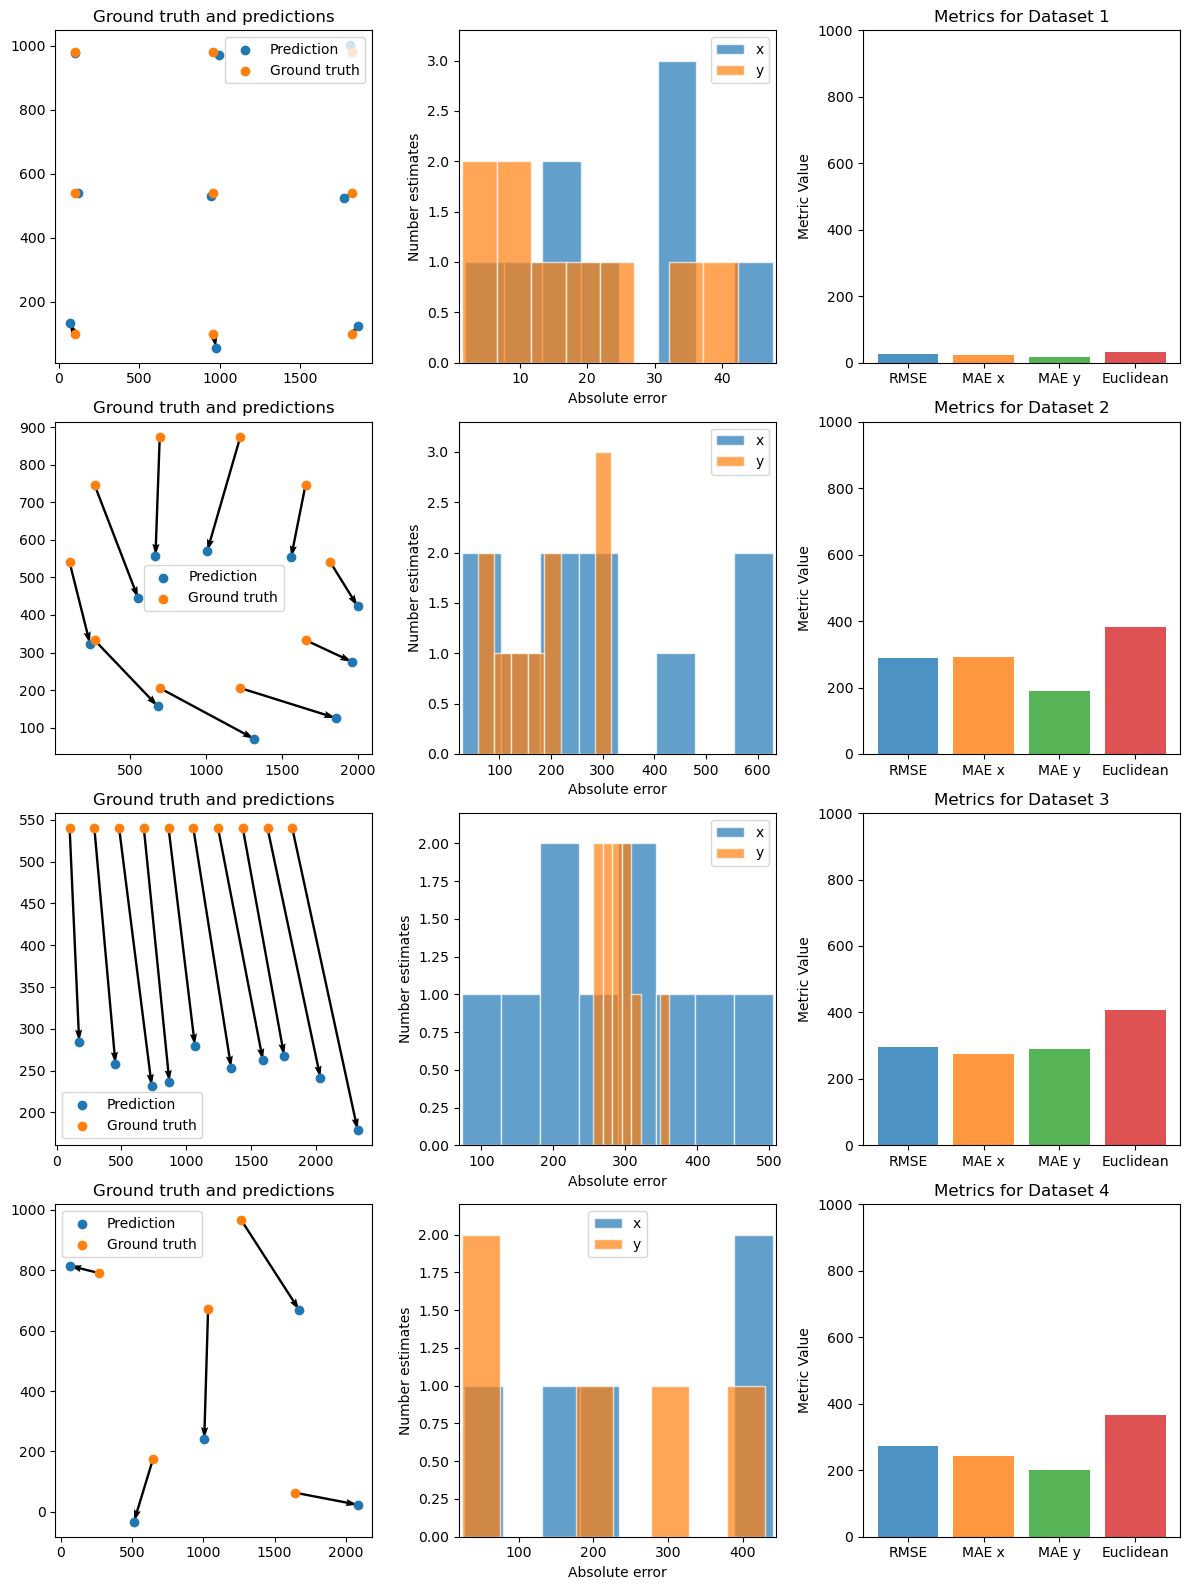

In [18]:
#Use this cell to train and evaluate your model...

results_linear_mads = results_for_model_pick(LinearGaze(), D_mads, D_mads, 'pupils_train', 'screen_coordinates_train', 'pupils_test', 'screen_coordinates_test', 4, 0)

iml_util.plot_results_grid(results_linear_mads, 4)


---
**Task 16 (medium): Evaluate♾️💡**
1. As in previous tasks, reflect on the results.


---

As seen in the previous tasks, when training on only a single pattern the model fails to generalize well for other patterns on the same test subject. We see above that the error is small for the training pattern (grid) set but much larger for the other patterns (circle, line, random). To improve the accuraccy of the model we could train it on more patterns.


# Optional improvements
You may experience that the models behave differently on your dataset than on `test_subject_0`
 and `test_subject_1`
. This can be due to several factors, some of which you may have already reflected on in Task 8 in exercise Data preprocessing
. If you experience interesting behaviour in the predictions of your model you are of course welcome to explore it further such as:
- Different combinations of training set (use can use the creation of `D3_mod`
 for inspiration as to how to manipulate the combination of data for training and testing).     - If you have multiple data sets in your group, you can incoorporate those or use the ones provided `test_subject_1`
. 


- Other evaluation metrics
- Take inspiration from the optional exercises below, to explore your dataset further.


---
**Task 17 (medium): Explore your dataset👩‍💻♾️💡**
1. Investigate your results and explore options for improving predictions and evaluation.


---## Scale the data
In this task, you will improve the model using normalization. In Task 13, you reflected on the effect of having a large scale difference between input and output. Use the data of `test_subject_1`
 in dictionary `D3`
. 

---
**Task 18 (medium): Scale the data👩‍💻**
1. Complete the functions `normalize`
 and `denormalize`
. 
2. Train and test a model using normalized data from `test_subject_1`
. (Note that for the _grid_ pattern you are using the same data for testing and training).
3. Visualize the results using the function `plot_results_grid`
. 


---

In [15]:
from sklearn.preprocessing import MinMaxScaler
def normalize(data_set):
    """
    Normalizes the pupil and screen coordinate data in the dataset using MinMaxScaler.
    Parameters:
        data_set (list of dict): A list of dictionaries where each dictionary contains training and testing data 
                                 for pupils and screen coordinates. Keys include:
                                 - 'pupils_train': N x 2 array of pupil coordinates for training.
                                 - 'screen_coordinates_train': N x 2 array of screen coordinates for training.
                                 - 'pupils_test': N x 2 array of pupil coordinates for testing.
                                 - 'screen_coordinates_test': N x 2 array of screen coordinates for testing. 
    Returns:
        d (list of dict): A list of dictionaries with normalized pupil and screen coordinate data.
                          Keys include:
                          - 'pupils_train': Normalized N x 2 array of pupil coordinates for training.
                          - 'screen_coordinates_train': Normalized N x 2 array of screen coordinates for training.
                          - 'pupils_test': Normalized N x 2 array of pupil coordinates for testing.
                          - 'screen_coordinates_test': Normalized N x 2 array of screen coordinates for testing.
        scaler (MinMaxScaler object): The fitted MinMaxScaler object used for normalization.
    """
    scaler = MinMaxScaler()
    # Write your code here

def denormalize(dataset, scaler):
    """
    Denormalizes predicted and ground truth coordinates and calculates errors and performance metrics.
    Parameters:
        dataset (list of dict): A list of dictionaries where each dictionary contains prediction results.
                                Keys include:
                                - 'predicted': N x 2 array of normalized predicted coordinates.
                                - 'ground_truth': N x 2 array of normalized ground truth coordinates.
        scaler (MinMaxScaler object): The MinMaxScaler object used for normalization, applied here to inverse-transform data.
    Returns:
        d (dict): A dictionary where each key corresponds to a dataset index, and each value contains the following:
                  - 'predicted': Denormalized N x 2 array of predicted coordinates.
                  - 'ground_truth': Denormalized N x 2 array of ground truth coordinates.
                  - 'errors': N x 2 array of absolute errors between predicted and ground truth coordinates.
                  - 'mse' (1 x 2 numpy array): Mean squared error for the x and y coordinates.
                  - 'rmse' (float): Root mean squared error (RMSE) across the dataset.
                  - 'dist' (float): Mean Euclidean distance between predicted and ground truth positions.
                  - 'mae' (1 x 2 numpy array): Mean absolute error for the x and y coordinates.
    """
    # Write your code here


# Write your code here for training, testing and visualizing results

ImportError: dlopen(/opt/anaconda3/envs/iml/lib/python3.11/site-packages/pyarrow/lib.cpython-311-darwin.so, 0x0002): Symbol not found: __ZN4absl12lts_2025012712log_internal10LogMessagelsIhTnNSt3__19enable_ifIXntsr4absl16HasAbslStringifyIT_EE5valueEiE4typeELi0EEERS2_RKS6_
  Referenced from: <B540F52C-E20A-301B-B105-287BA4CB5B4A> /opt/anaconda3/envs/iml/lib/libre2.11.dylib
  Expected in:     <621B4947-F73F-3962-8DDB-2484D6B77411> /opt/anaconda3/envs/iml/lib/libabsl_log_internal_message.2501.0.0.dylib


---
**Task 19 (medium): Evaluation♾️💡**
1. Evaluate the results based on the plots and compare to the results from Task 11.
2. What possible pitfalls could there be in normalizing the data?
3. The pattern _line_ though improved, occurs to perform the worst, use your previous reflection from Task 8 in exercise Data preprocessing
 to reflect on why.


---

In [ ]:
#Write your reflections here...

## Improve the model
This final part of the exercise requires you to modify  the gaze model $f_{\mathbf{w}}(x,y)$ into a quadratic model. As in [Task 5](#task_model), you will create a model for each output coordinate, i.e. $x', y'$. 
**Note:** In this step you create one model for each output coordinate seperately but it is possible to create a single model that simultaneously maps the $x'$- and $y'$-coordinates. However, we leave it as an optional exercise for you to figure out how to do this. Hint: You have to combine the design and parameter matrices.

Since the model is two-dimensional, the quadratic polynomial has  more model parameters than for one dimension model. The equation for each axis is:

$$
f(x, y) = a\cdot x^2 + b\cdot y^2 + c\cdot xy + d\cdot x + e\cdot y + f.
$$
The design matrices then have the following form:

---
**Task 20 (medium): Model improvements👩‍💻💡**
1. **Design matrix:** 
Argue why the desginmatrix for each output coordinate of the gaze mapping function is given by 

$$
D_x = D_y = \begin{bmatrix}
 		x_1^2 & y_1^2 & x_1y_1 & x_1 & y_1 & 1\\
  		x_2^2 & y_2^2 & x_2y_2 & x_2 & y_2 & 1\\
  		\vdots &&&&& \\
   		x_2^2 & y_2^2 & x_ny_n & x_n & y_n & 1\\
 	\end{bmatrix}.$$


2. **Implement model:** Implement the 2. order model and train it (calibrate) on each dataset.

3. **Evaluate:** Repeat the evaluation steps you did for the linear model above in [Task 2](#evaluation) (subtask 1-2). Additionally:
    - Create a barplot of the _rmse_ of both models for each dataset. Use the `bar_comparison_plot`
 function. 


4. **Compare with linear results:**
    - Is there a significant difference between the _rmse_'s of the linear and 2. order models? Explain why either is the case. Use your previous discussion of model limitations and error sources in your explanation.
    - Compare the scatter plots for the predictions vs. ground-truth for both models. Is there a qualitative difference in performance in some instances? Explain why either model performs better in particular cases and relate your answer to the previous question.




---

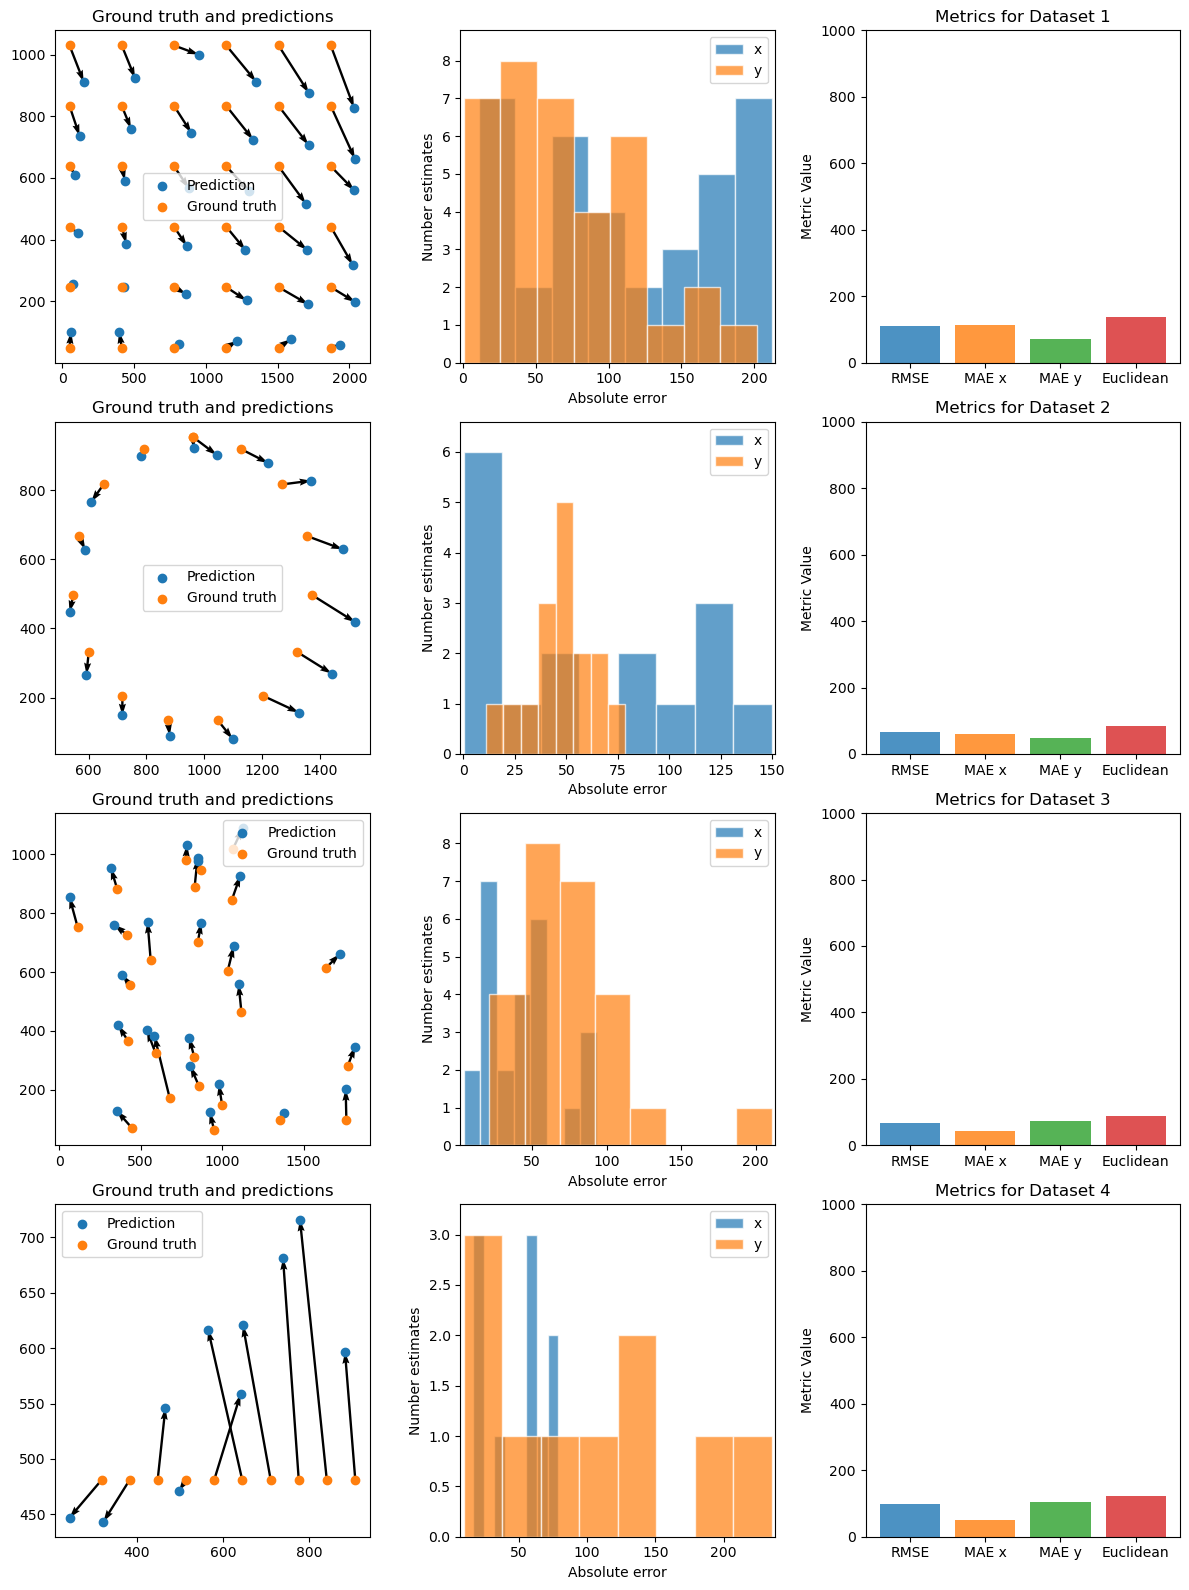

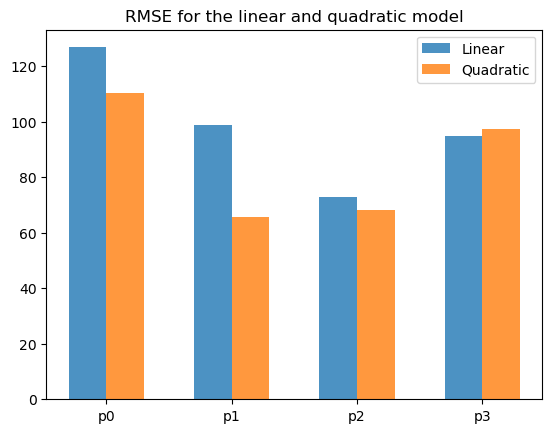

In [ ]:
def get_design_matrix_quad(pupil_positions):
    design_rows = [
        np.array([
            [1, x, y ,x*y, x**2, y**2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, x, y ,x*y, x**2, y**2]
        ])
        for x, y in pupil_positions
    ]
    return np.vstack(design_rows)

def quad(param, x):
    return param[0] + param[1]*x[0] + param[2]*x[1] + param[3]*x[0]*x[1] + param[4]*x[0]**2 + param[5]*x[1]**2


class QuadGaze(GazeModel):
    def calibrate(self, dataset, pupil_training_set, screen_training_set):
        """
        Calibrates the LinearGaze model by fitting two linear regression models for x and y coordinates based 
        on the training dataset.

        Parameters:
            dataset (dict): The dictionary D containing the training data with two keys:
                - "pupils_train" (N x 2 numpy array): n samples, 2 features (px, py) representing pupil 
                  positions.
                - "positions_train" (N x 2 numpy array): n samples, 2 features (screen coordinate x, screen coordinates y) representing
                  the true gaze positions being the screen coordinates.

        Returns:
            None: Updates the model's parameters (self.model_x, self.model_y) based on 
            the least squares solution for x and y positions.
        """
        pupil_data = dataset[pupil_training_set]
        selected_points = np.array(pupil_data)
        design = get_design_matrix_quad(selected_points)
        
        screen_coordinates = dataset[screen_training_set]
        selected_screencoords = np.array(screen_coordinates).reshape(-1, 1)
        
        weights,_,_,_ = np.linalg.lstsq(design, selected_screencoords)
        model_x = np.array(weights[:6]).flatten()
        model_y = np.array(weights[6:12]).flatten()
        self.model_x = model_x
        self.model_y = model_y
        
        return model_x, model_y


    def predict(self, pupil):
        # Write your implementation
        return [quad(self.model_x, pupil), quad(self.model_y, pupil)]


results_quad = results_for_model(QuadGaze(), D, D, 'pupils_n_train', 'screen_coordinates_train', 'pupils_n_test', 'screen_coordinates_test', 4)


# Write your implementation here
iml_util.plot_results_grid(results_quad, 4)

linear_rmses = [results_linear[i]["rmse"] for i in range(4)]
quad_rmses   = [results_quad[i]["rmse"] for i in range(4)]
iml_util.bar_comparison_plot(linear_rmses, quad_rmses)


---
**Task 21 (medium): Evaluation♾️💡**
1. Reflect on how the higher order model performs compared to the linear model.    - Does it reduce the error more effectively than the linear model?
    - Does it seem to overfit the training data? Why? Why not?
    - When plotting the residuals, do you notice any patterns for the higher-order model that are not present in the linear model?




---
**Submission**
Your submission must contain the **jupyter notebook** and the folder `sessions`
 maintaining the structure but only containing the `.csv`
 files for each testsubject, trial and pattern used to complete the assignment (do not include images and video). Make sure you maintain the same folderstructure for the TA's to be able to run the assignment: <br>
- `mean_pupil_coordinate`
 <br>
- `screen_coordinates`

Use the [learnIt](https://learnit.itu.dk/)
 page for submission of the handin and [refer to iml.itu.dk for submission details.](https://iml.itu.dk/01-about_the_course/01-AboutTheCourse.html)



**Important**
In case you do **not** want to share your data with the TA's for assessment, train and evaluate the models using the data and create and place images of evaluation plots in the folder `sessions/output/individual`
 in the `sessions`
 folder containing the data. Comment out the coding cells for this part of the assigment to allow TA's to run the entire notebook without errors. Submit the `sessions`
 folder with the images and without your data. Refer to evaluation plots by name in your reflections.

